# Preparing Data

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm


metadata = pd.read_csv('metadata.csv')
erp_files = glob.glob('EEG_Measurements/*.csv')
erp_data = []

for file in erp_files:
    erp = pd.read_csv(file)
    participant_number = os.path.basename(file).split('_')[-1].split('.')[0]  
    erp['participant'] = participant_number

    file_name = os.path.basename(file)
    word_info = file_name.split('_')
    
    type_info = word_info[-2]  
    primary_language = word_info[1].split('-')[0]  
    target_language = word_info[1].split('-')[1]  
    
    erp['word_type'] = type_info
    erp['primary_language'] = primary_language
    erp['target_language'] = target_language
    erp_data.append(erp)


combined_erp_data = pd.concat(erp_data, ignore_index=True)
metadata['spanish_bilingual'] = metadata['spanish'].apply(lambda x: 1 if x > 0 else 0)
combined_erp_data.head()

In [ ]:
time_points = np.linspace(-100, 900, 256)  
for erp in erp_data:
    erp['time'] = time_points

# Splitting Columns

In [ ]:
n400_window = (350, 450)
n170_window = (120, 220)
p200_window = (150, 250)
n250_window = (200, 300)
p600_window = (550, 650)
baseline_window = (-100, 0)

spanish_pairs = ['spanish-english', 'english-spanish', 'spanish-spanish']

electrode_columns = ["Fp1","Fpz","Fp2","F7","F3","Fz","F4","F8","FC5","FC1","FC2","FC6","T7","C3","Cz","C4","T8","CP5","CP1","CP2","CP6","P7","P3","Pz","P4","P8","POz","O1","Oz","O2"]  


def extract_local_max(data, start, end, electrode):
    
    time_filtered_data = data[(data['time'] >= start) & (data['time'] <= end)]
    
    return time_filtered_data[electrode].max()


def extract_local_min(data, start, end, electrode):
    
    time_filtered_data = data[(data['time'] >= start) & (data['time'] <= end)]
    
    return time_filtered_data[electrode].min()


def baseline_correct(data, baseline_start, baseline_end):
    baseline_data = data[(data['time'] >= baseline_start) & (data['time'] <= baseline_end)]
    for electrode in electrode_columns:
        baseline_mean = baseline_data[electrode].mean()  
        
        data.loc[data['time'] > baseline_end, electrode] -= baseline_mean
    return data

def categorize_row(row):
    language_pair = f"{row['primary_language']}-{row['target_language']}"
    
    if row['word_type'] == 'translated' and language_pair in spanish_pairs:
        return 0
    elif row['word_type'] == 'unrelated' and language_pair in spanish_pairs:
        return 1
    else:
        return 2

features = []

for erp in tqdm(erp_data, desc="looping through file"):
    participant_id = erp['participant'].iloc[0]
    word_type = erp['word_type'].iloc[0]
    primary_language = erp['primary_language'].iloc[0]
    target_language = erp['target_language'].iloc[0]
    
    erp = baseline_correct(erp, *baseline_window)
    
    amplitude_data = {
        'participant': participant_id,
        'word_type': word_type,
        'primary_language': primary_language,
        'target_language': target_language
    }
   
    
    for electrode in electrode_columns:
        
        n400_max = extract_local_max(erp, *n400_window, electrode)
        n400_min = extract_local_min(erp, *n400_window, electrode)
        amplitude_data[f'n400_{electrode}_max'] = n400_max
        amplitude_data[f'n400_{electrode}_min'] = n400_min
        
        
        n170_max = extract_local_max(erp, *n170_window, electrode)
        n170_min = extract_local_min(erp, *n170_window, electrode)
        amplitude_data[f'n170_{electrode}_max'] = n170_max
        amplitude_data[f'n170_{electrode}_min'] = n170_min
        
        
        p200_max = extract_local_max(erp, *p200_window, electrode)
        p200_min = extract_local_min(erp, *p200_window, electrode)
        amplitude_data[f'p200_{electrode}_max'] = p200_max
        amplitude_data[f'p200_{electrode}_min'] = p200_min

        p600_max = extract_local_max(erp, *p600_window, electrode)
        p600_min = extract_local_min(erp, *p600_window, electrode)
        amplitude_data[f'p600_{electrode}_max'] = p600_max
        amplitude_data[f'p600_{electrode}_min'] = p600_min

        n250_max = extract_local_max(erp, *n250_window, electrode)
        n250_min = extract_local_min(erp, *n250_window, electrode)
        amplitude_data[f'n250_{electrode}_max'] = n250_max
        amplitude_data[f'n250_{electrode}_min'] = n250_min
    
    features.append(amplitude_data)


features_df = pd.DataFrame(features)
features_df['participant'] = features_df['participant'].astype(int)
final_data = pd.merge(features_df, metadata, on='participant')

final_data['category'] = final_data.apply(categorize_row, axis=1)

final_data.to_csv('final_data_2.csv', index=False)

In [1]:
import pandas as pd
final_data = pd.read_csv('final_data_2.csv')

In [2]:
cols = final_data.columns.tolist()
cols.insert(4, cols.pop(cols.index('category')))
final_data = final_data[cols]
final_data.head()

,participant,word_type,primary_language,target_language,category,n400_Fp1_max,n400_Fp1_min,n170_Fp1_max,n170_Fp1_min,p200_Fp1_max,...,p200_O2_min,p600_O2_max,p600_O2_min,n250_O2_max,n250_O2_min,spanish,french,german,other,spanish_bilingual
0,1,translation,english,english,2,38.418221,21.986221,24.476221,5.577221,24.476221,...,-21.052014,-25.258014,-33.354014,-1.641014,-17.675014,0,0,0,0,0
1,10,translation,english,english,2,7.746407,-10.108593,23.173407,3.451407,22.935407,...,-11.098516,3.078484,-18.215516,13.177484,4.255484,1,0,0,1,1
2,11,translation,english,english,2,38.209372,16.443372,20.442372,3.774372,21.464372,...,-5.889178,25.943822,0.712822,19.766822,-6.589178,0,0,0,0,0
3,12,translation,english,english,2,43.020097,27.705097,65.285097,28.857097,67.615097,...,-11.319496,14.510504,-22.351496,30.590504,-11.319496,0,1,0,0,0
4,13,translation,english,english,2,44.251257,27.559257,60.332257,22.610257,60.332257,...,-57.015307,-20.839307,-71.725307,-24.413307,-41.330307,1,0,0,1,1


In [3]:
final_data.iloc[:, 4:-5].head()

,category,n400_Fp1_max,n400_Fp1_min,n170_Fp1_max,n170_Fp1_min,p200_Fp1_max,p200_Fp1_min,p600_Fp1_max,p600_Fp1_min,n250_Fp1_max,...,n400_O2_max,n400_O2_min,n170_O2_max,n170_O2_min,p200_O2_max,p200_O2_min,p600_O2_max,p600_O2_min,n250_O2_max,n250_O2_min
0,2,38.418221,21.986221,24.476221,5.577221,24.476221,5.577221,52.620221,28.515221,29.111221,...,-11.396014,-24.396014,-1.641014,-21.153014,-1.641014,-21.052014,-25.258014,-33.354014,-1.641014,-17.675014
1,2,7.746407,-10.108593,23.173407,3.451407,22.935407,3.451407,14.354407,-7.316593,17.382407,...,13.839484,-6.009516,14.298484,-11.098516,14.298484,-11.098516,3.078484,-18.215516,13.177484,4.255484
2,2,38.209372,16.443372,20.442372,3.774372,21.464372,3.774372,34.828372,24.108372,21.464372,...,18.317822,5.381822,19.766822,3.170822,19.766822,-5.889178,25.943822,0.712822,19.766822,-6.589178
3,2,43.020097,27.705097,65.285097,28.857097,67.615097,39.035097,60.273097,27.428097,70.090097,...,11.711504,-17.469496,3.692504,-11.319496,9.615504,-11.319496,14.510504,-22.351496,30.590504,-11.319496
4,2,44.251257,27.559257,60.332257,22.610257,60.332257,28.316257,47.007257,22.220257,52.907257,...,-34.392307,-45.003307,-24.413307,-57.015307,-24.413307,-57.015307,-20.839307,-71.725307,-24.413307,-41.330307


# Random Forest

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = final_data.iloc[:, 4:-5]
y = final_data['spanish_bilingual']
data = pd.concat([X, y], axis=1)


class_0 = data[data['spanish_bilingual'] == 0]
class_1 = data[data['spanish_bilingual'] == 1]
class_0_downsampled = class_0.sample(n=len(class_1))
balanced_data = pd.concat([class_0_downsampled, class_1]).sample(frac=1).reset_index(drop=True)


X_balanced = balanced_data.iloc[:, :-1]
y_balanced = balanced_data['spanish_bilingual']


X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced)


param_grid = {
    'n_estimators': [250, 300, 500],            
    'max_depth': [25, 30, 40],                   
    'min_samples_split': [5],                 
    'min_samples_leaf': [1],                   
    'max_features': ['sqrt', 'log2']         
}


rf = RandomForestClassifier()


random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_grid,
    n_iter=50,                   
    cv=5,                         
    scoring='accuracy',           
    n_jobs=-1,                    
)


random_search.fit(X_train, y_train)


best_rf_model = random_search.best_estimator_


y_pred = best_rf_model.predict(X_test)


print(f'Best Parameters: {random_search.best_params_}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

c:\Users\tommy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
Accuracy: 0.7428288822947576
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1011
           1       0.75      0.73      0.74      1011

    accuracy                           0.74      2022
   macro avg       0.74      0.74      0.74      2022
weighted avg       0.74      0.74      0.74      2022

[[769 242]
 [278 733]]


In [29]:
import pandas as pd
import pickle

with open('best_rf_model_2.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

## Checkpoint Read

In [8]:
import pickle
from sklearn.model_selection import train_test_split
with open('best_rf_model_2.pkl', 'rb') as file:
    best_rf_model = pickle.load(file)


X = final_data.iloc[:, 4:-5]
y = final_data['spanish_bilingual']
data = pd.concat([X, y], axis=1)


class_0 = data[data['spanish_bilingual'] == 0]
class_1 = data[data['spanish_bilingual'] == 1]
class_0_downsampled = class_0.sample(n=len(class_1))
balanced_data = pd.concat([class_0_downsampled, class_1]).sample(frac=1).reset_index(drop=True)


X_balanced = balanced_data.iloc[:, :-1]
y_balanced = balanced_data['spanish_bilingual']


X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced)

C:\Users\tommy\AppData\Local\Temp\ipykernel_36024\871381200.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


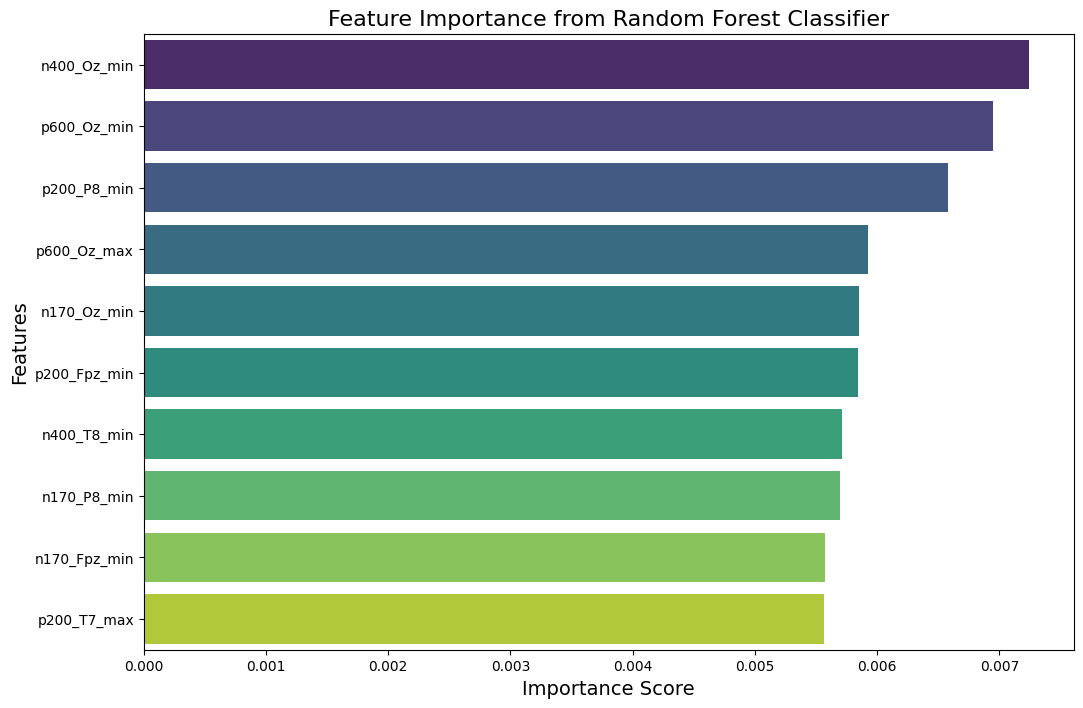

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


importances = best_rf_model.feature_importances_


features = X_train.columns  
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})


importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)


plt.figure(figsize=(12, 8))


sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


plt.title('Feature Importance from Random Forest Classifier', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)


plt.show()

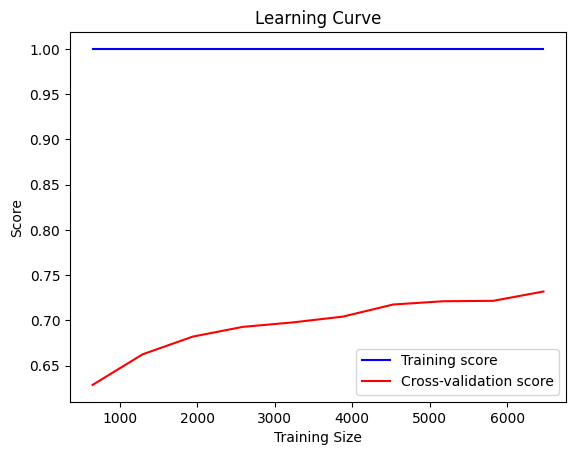

In [13]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), cv = 5)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='red')
    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()

plot_learning_curve(best_rf_model, X_train, y_train)

BAD

# XGB

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


X = final_data.iloc[:, 4:-5]
y = final_data['spanish_bilingual']


smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


model = XGBClassifier()
rfe = RFE(model, n_features_to_select=30)  
X_train_rfe = rfe.fit_transform(X_train_pca, y_train)
X_test_rfe = rfe.transform(X_test_pca)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


skf = StratifiedKFold(n_splits=5, shuffle=True, )
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_grid,
    n_iter=50, 
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train_rfe, y_train)


best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test_rfe)


print(f'Best Parameters: {random_search.best_params_}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\tommy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Accuracy: 0.8470437017994858
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3112
           1       0.83      0.87      0.85      3112

    accuracy                           0.85      6224
   macro avg       0.85      0.85      0.85      6224
weighted avg       0.85      0.85      0.85      6224

[[2568  544]
 [ 408 2704]]


In [48]:
cv_results = random_search.cv_results_

print("Mean CV Test Score: ", cv_results['mean_test_score'])
print("Std Dev CV Test Score: ", cv_results['std_test_score'])

Mean CV Test Score:  [0.80031289 0.77118954 0.75532203 0.77729553 0.82361158 0.77745605
 0.8343372  0.70896596 0.81079737 0.81561797 0.75371544 0.7992286
 0.74299006 0.6970353  0.68438166 0.76898015 0.70619412 0.81991624
 0.71045226 0.77705419 0.69779867 0.7601426  0.79629595 0.71149672
 0.83164591 0.7564869  0.81887189 0.79537221 0.71442896 0.81991629
 0.77697394 0.79135515 0.7965371  0.79577367 0.69811988 0.73780799
 0.75777251 0.73186304 0.77512618 0.80252238 0.70036956 0.7826782
 0.75853585 0.68301596 0.69787882 0.72515446 0.73612084 0.73804893
 0.79758153 0.72933224]
Std Dev CV Test Score:  [0.00707556 0.0052946  0.00790892 0.00834423 0.00780565 0.00683983
 0.00659778 0.00134479 0.00607622 0.00486012 0.00612001 0.00756811
 0.0051013  0.0028782  0.00355281 0.00622412 0.0024253  0.00341155
 0.00426147 0.00914587 0.00413456 0.00666228 0.00674967 0.00450425
 0.00478691 0.00796001 0.00435273 0.00477965 0.00405555 0.00621796
 0.00598252 0.00645903 0.00560589 0.00582017 0.00298585 0.0062

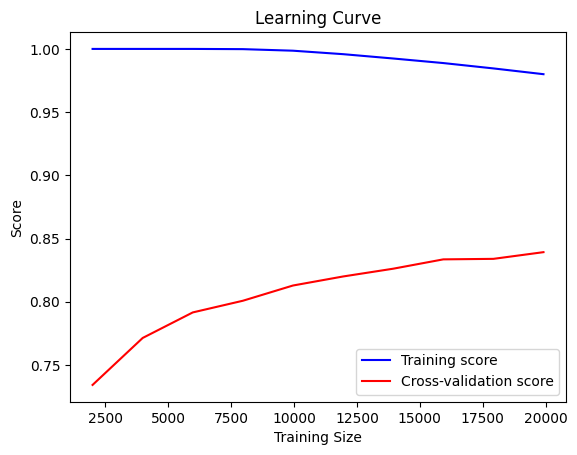

In [49]:
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), cv=skf)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='red')
    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()

plot_learning_curve(best_xgb_model, X_train_rfe, y_train)

STILL BAD

overfitting on data probably because of SMOTE

# XGB w/ measures against overfitting

In [2]:
import pandas as pd
final_data = pd.read_csv("final_data_2.csv")

In [4]:
final_data.iloc[:, 4:-6].head()

,n400_Fp1_max,n400_Fp1_min,n170_Fp1_max,n170_Fp1_min,p200_Fp1_max,p200_Fp1_min,p600_Fp1_max,p600_Fp1_min,n250_Fp1_max,n250_Fp1_min,...,n400_O2_max,n400_O2_min,n170_O2_max,n170_O2_min,p200_O2_max,p200_O2_min,p600_O2_max,p600_O2_min,n250_O2_max,n250_O2_min
0,38.418221,21.986221,24.476221,5.577221,24.476221,5.577221,52.620221,28.515221,29.111221,17.665221,...,-11.396014,-24.396014,-1.641014,-21.153014,-1.641014,-21.052014,-25.258014,-33.354014,-1.641014,-17.675014
1,7.746407,-10.108593,23.173407,3.451407,22.935407,3.451407,14.354407,-7.316593,17.382407,3.451407,...,13.839484,-6.009516,14.298484,-11.098516,14.298484,-11.098516,3.078484,-18.215516,13.177484,4.255484
2,38.209372,16.443372,20.442372,3.774372,21.464372,3.774372,34.828372,24.108372,21.464372,11.852372,...,18.317822,5.381822,19.766822,3.170822,19.766822,-5.889178,25.943822,0.712822,19.766822,-6.589178
3,43.020097,27.705097,65.285097,28.857097,67.615097,39.035097,60.273097,27.428097,70.090097,42.853097,...,11.711504,-17.469496,3.692504,-11.319496,9.615504,-11.319496,14.510504,-22.351496,30.590504,-11.319496
4,44.251257,27.559257,60.332257,22.610257,60.332257,28.316257,47.007257,22.220257,52.907257,28.316257,...,-34.392307,-45.003307,-24.413307,-57.015307,-24.413307,-57.015307,-20.839307,-71.725307,-24.413307,-41.330307


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import callback

X = final_data.iloc[:, 4:-6]
y = final_data['spanish_bilingual']


smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
rfe = RFE(model, n_features_to_select=30)  
X_train_rfe = rfe.fit_transform(X_train_pca, y_train)
X_test_rfe = rfe.transform(X_test_pca)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 1, 5]
}


xgb_model = XGBClassifier(early_stopping_rounds=10, use_label_encoder=False, eval_metric='logloss')


skf = StratifiedKFold(n_splits=5, shuffle=True)


random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
)

evals = [(X_train_rfe, y_train), (X_test_rfe, y_test)]

random_search.fit(X_train_rfe, y_train, eval_set=evals)

In [9]:
evals = [(X_train_rfe, y_train), (X_test_rfe, y_test)]

In [ ]:
# best_params = random_search.best_params_

best_params = {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 5, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'min_child_weight':5}

In [ ]:
best_xgb_model = XGBClassifier(**best_params, use_label_encoder=False, early_stopping_rounds=10, eval_metric='logloss')


best_xgb_model.fit(X_train_rfe, y_train, eval_set=evals)


y_pred = best_xgb_model.predict(X_test_rfe)


y_train_pred = best_xgb_model.predict(X_train_rfe)
train_accuracy = accuracy_score(y_train, y_train_pred)


print(f'Best Parameters: {best_params}')
print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[0]	validation_0-logloss:0.68995	validation_1-logloss:0.69004
[1]	validation_0-logloss:0.68689	validation_1-logloss:0.68708
[2]	validation_0-logloss:0.68382	validation_1-logloss:0.68418
[3]	validation_0-logloss:0.68098	validation_1-logloss:0.68144
[4]	validation_0-logloss:0.67848	validation_1-logloss:0.67890
[5]	validation_0-logloss:0.67599	validation_1-logloss:0.67630
[6]	validation_0-logloss:0.67311	validation_1-logloss:0.67356
[7]	validation_0-logloss:0.67088	validation_1-logloss:0.67153
[8]	validation_0-logloss:0.66814	validation_1-logloss:0.66885
[9]	validation_0-logloss:0.66576	validation_1-logloss:0.66651
[10]	validation_0-logloss:0.66374	validation_1-logloss:0.66458
[11]	validation_0-logloss:0.66174	validation_1-logloss:0.66268
[12]	validation_0-logloss:0.65990	validation_1-logloss:0.66089
[13]	validation_0-logloss:0.65743	validation_1-logloss:0.65853
[14]	validation_0-logloss:0.65562	validation_1-logloss:0.65671
[15]	validation_0-logloss:0.65367	validation_1-logloss:0.65490
[1

c:\Users\tommy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-logloss:0.63202	validation_1-logloss:0.63463
[29]	validation_0-logloss:0.63022	validation_1-logloss:0.63284
[30]	validation_0-logloss:0.62878	validation_1-logloss:0.63161
[31]	validation_0-logloss:0.62748	validation_1-logloss:0.63040
[32]	validation_0-logloss:0.62594	validation_1-logloss:0.62900
[33]	validation_0-logloss:0.62471	validation_1-logloss:0.62796
[34]	validation_0-logloss:0.62361	validation_1-logloss:0.62683
[35]	validation_0-logloss:0.62214	validation_1-logloss:0.62566
[36]	validation_0-logloss:0.62093	validation_1-logloss:0.62452
[37]	validation_0-logloss:0.61957	validation_1-logloss:0.62316
[38]	validation_0-logloss:0.61836	validation_1-logloss:0.62212
[39]	validation_0-logloss:0.61709	validation_1-logloss:0.62086
[40]	validation_0-logloss:0.61596	validation_1-logloss:0.61992
[41]	validation_0-logloss:0.61475	validation_1-logloss:0.61879
[42]	validation_0-logloss:0.61375	validation_1-logloss:0.61793
[43]	validation_0-logloss:0.61259	validation_1-logloss:

[0]	validation_0-logloss:0.69013
[1]	validation_0-logloss:0.68712
[2]	validation_0-logloss:0.68454
[3]	validation_0-logloss:0.68167
[4]	validation_0-logloss:0.67892
[5]	validation_0-logloss:0.67647
[6]	validation_0-logloss:0.67393
[7]	validation_0-logloss:0.67156
[8]	validation_0-logloss:0.66964
[9]	validation_0-logloss:0.66768
[10]	validation_0-logloss:0.66579
[11]	validation_0-logloss:0.66388
[12]	validation_0-logloss:0.66179
[13]	validation_0-logloss:0.66007
[14]	validation_0-logloss:0.65848
[15]	validation_0-logloss:0.65675
[16]	validation_0-logloss:0.65492
[17]	validation_0-logloss:0.65336
[18]	validation_0-logloss:0.65154
[19]	validation_0-logloss:0.64955
[20]	validation_0-logloss:0.64820
[21]	validation_0-logloss:0.64676
[22]	validation_0-logloss:0.64549
[23]	validation_0-logloss:0.64347
[24]	validation_0-logloss:0.64235
[25]	validation_0-logloss:0.64076
[26]	validation_0-logloss:0.63958
[27]	validation_0-logloss:0.63807


c:\Users\tommy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-logloss:0.63679
[29]	validation_0-logloss:0.63553
[30]	validation_0-logloss:0.63452
[31]	validation_0-logloss:0.63277
[32]	validation_0-logloss:0.63170
[33]	validation_0-logloss:0.63056
[34]	validation_0-logloss:0.62916
[35]	validation_0-logloss:0.62802
[36]	validation_0-logloss:0.62654
[37]	validation_0-logloss:0.62546
[38]	validation_0-logloss:0.62431
[39]	validation_0-logloss:0.62343
[40]	validation_0-logloss:0.62262
[41]	validation_0-logloss:0.62139
[42]	validation_0-logloss:0.62042
[43]	validation_0-logloss:0.61954
[44]	validation_0-logloss:0.61862
[45]	validation_0-logloss:0.61793
[46]	validation_0-logloss:0.61707
[47]	validation_0-logloss:0.61598
[48]	validation_0-logloss:0.61504
[49]	validation_0-logloss:0.61416
[50]	validation_0-logloss:0.61329
[51]	validation_0-logloss:0.61227
[52]	validation_0-logloss:0.61120
[53]	validation_0-logloss:0.61051
[54]	validation_0-logloss:0.60974
[55]	validation_0-logloss:0.60881
[56]	validation_0-logloss:0.60813
[57]	validatio

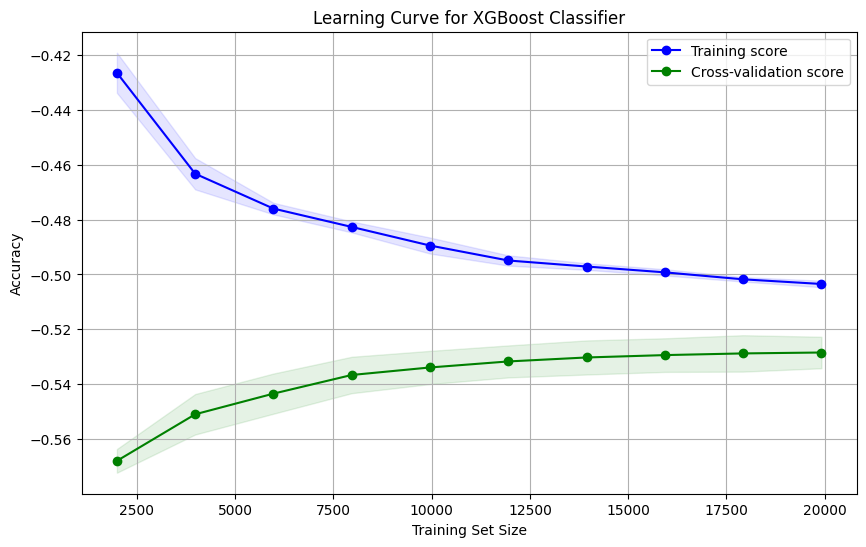

In [ ]:
from sklearn.model_selection import train_test_split


X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X_train_rfe, y_train, test_size=0.2)

best_xgb_model = XGBClassifier(**best_params, use_label_encoder=False, early_stopping_rounds=10, eval_metric='logloss')

best_xgb_model.fit(X_train_split, y_train_split, eval_set=[(X_valid, y_valid)])

params = best_xgb_model.get_params()


params["early_stopping_rounds"] = None
best_xgb_model.set_params(**params)


train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model, X_train_rfe, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.xlabel('Training Set Size')
plt.ylabel('neg_log_loss')
plt.title('Learning Curve for XGBoost Classifier')
plt.legend(loc='best')
plt.grid()
plt.show()


Better

# hyperparamters have sway on overfitting and accuracy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, ParameterGrid, learning_curve


hyperparameter_grid = {
    'subsample': [0.6, 0.8, 1.0],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 5, 10],
    'n_estimators': [300],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.05],
    'colsample_bytree': [0.8],
    'min_child_weight': [1, 5, 10]
}


param_combinations = list(ParameterGrid(hyperparameter_grid))

import os
results = []
output_dir = 'xgb graphs'

for params in param_combinations:
    
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10)

    
    X_train_split, X_valid, y_train_split, y_valid = train_test_split(
        X_train_rfe, y_train, test_size=0.2)

    
    model.fit(X_train_split, y_train_split, eval_set=[(X_valid, y_valid)], verbose=0)
    all_params = model.get_params()

    all_params["early_stopping_rounds"] = None
    model.set_params(**all_params)
    
    y_pred = model.predict(X_test_rfe)

    
    train_accuracy = accuracy_score(y_train_split, model.predict(X_train_split))
    test_accuracy = accuracy_score(y_test, y_pred)
    
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_rfe, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10))

    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    
    results.append({
        'params': params,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'train_sizes': train_sizes,
        'train_scores_mean': train_scores_mean,
        'train_scores_std': train_scores_std,
        'test_scores_mean': test_scores_mean,
        'test_scores_std': test_scores_std
    })

    
    print(f'Parameters: {params}')
    print(f'Training Accuracy: {train_accuracy:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, color='blue', alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, color='green', alpha=0.1)
    
    plt.xlabel('Training Set Size')
    plt.ylabel('Neg Log Loss')
    print(f'Learning Curve for XGBoost Classifier\nParams: {params}')
    plt.title(f'Learning Curve for XGBoost Classifier\n'
          f'Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}')
    
    plt.legend(loc='best')
    param_text = '\n'.join([f'{key}: {value}' for key, value in params.items()])
    plt.gca().text(0.02, 0.95, param_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))


    plt.grid()
    file_name = f"xgb_learning_curve_train_{train_accuracy:.4f}_test_{test_accuracy:.4f}.png"
    plt.savefig(os.path.join(output_dir, file_name))

    plt.show()
    

# best model

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, ParameterGrid, learning_curve
best_params = {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'min_child_weight':1}
evals = [(X_train_rfe, y_train), (X_test_rfe, y_test)]
best_xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')

best_xgb_model.fit(X_train_rfe, y_train)


y_pred = best_xgb_model.predict(X_test_rfe)


y_train_pred = best_xgb_model.predict(X_train_rfe)
train_accuracy = accuracy_score(y_train, y_train_pred)


print(f'Best Parameters: {best_params}')
print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

c:\Users\tommy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:15:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'min_child_weight': 1}
Training Accuracy: 0.8555073511689564
Test Accuracy: 0.803181233933162
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      3112
           1       0.78      0.84      0.81      3112

    accuracy                           0.80      6224
   macro avg       0.80      0.80      0.80      6224
weighted avg       0.80      0.80      0.80      6224

[[2400  712]
 [ 513 2599]]


In [ ]:

pca_component_names = [f'PCA_Component_{i+1}' for i in range(X_train_rfe.shape[1])]


feature_importances_df = pd.DataFrame({
    'Feature': pca_component_names,
    'Importance': feature_importances
})


feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)


top_10_features = feature_importances_df.head(10)
print("Top 10 Most Important Features:")
print(top_10_features)


C:\Users\tommy\AppData\Local\Temp\ipykernel_42448\783780175.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


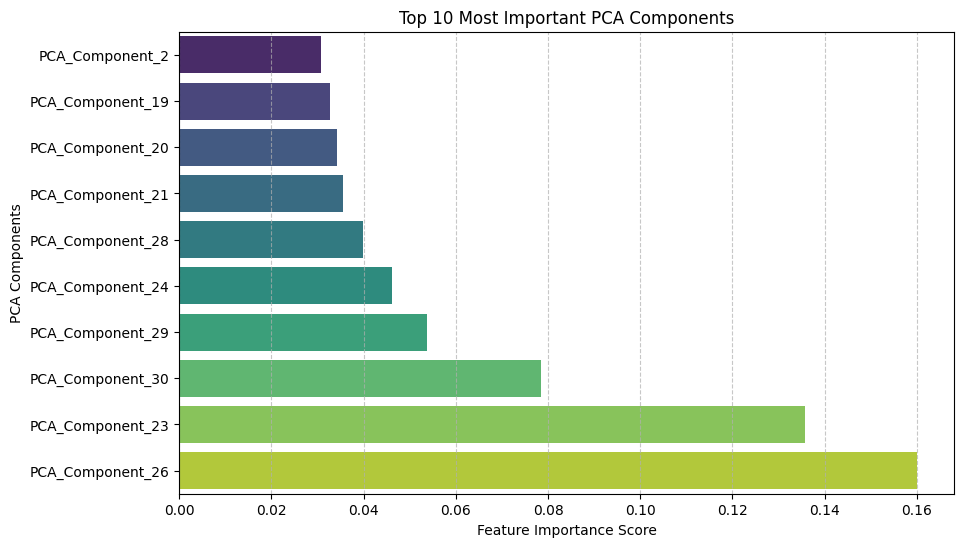

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


top_10_features_sorted = top_10_features.sort_values(by='Importance', ascending=True)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_features_sorted,
    x='Importance',
    y='Feature',
    palette='viridis'
)


plt.xlabel('Feature Importance Score')
plt.ylabel('PCA Components')
plt.title('Top 10 Most Important PCA Components')
plt.grid(axis='x', linestyle='--', alpha=0.7)


plt.show()


In [ ]:

top_components = [
    "PCA_Component_26", "PCA_Component_23", "PCA_Component_30",
    "PCA_Component_29", "PCA_Component_24", "PCA_Component_28",
    "PCA_Component_21", "PCA_Component_20", "PCA_Component_19",
    "PCA_Component_2"
]


pca_loadings_df = pd.DataFrame(
    pca.components_,
    columns=original_features,
    index=[f"PCA_Component_{i+1}" for i in range(pca.components_.shape[0])]
)


num_features = 10  

for component in top_components:
    if component in pca_loadings_df.index:  
        print(f"\nTop {num_features} features for {component}:")
        top_features = pca_loadings_df.loc[component].abs().nlargest(num_features)
        print(top_features)



Top 10 features for PCA_Component_26:
n400_P4_max    0.203005
n170_P4_min    0.193784
p600_P4_max    0.190586
n400_P4_min    0.188574
n170_P4_max    0.184702
p200_P4_min    0.181008
p600_P4_min    0.179398
p200_P4_max    0.174538
n250_P4_max    0.169984
n250_P4_min    0.162727
Name: PCA_Component_26, dtype: float64

Top 10 features for PCA_Component_23:
spanish         0.369650
n250_Fz_min     0.139646
n170_Fp2_max    0.130299
n170_FC6_max    0.128322
n170_Cz_max     0.125977
n250_F3_min     0.124734
n250_P4_max     0.122803
n250_Fz_max     0.121042
n250_FC1_min    0.120718
n250_CP5_max    0.120486
Name: PCA_Component_23, dtype: float64

Top 10 features for PCA_Component_30:
n170_P3_max    0.173973
p200_P3_max    0.169332
n250_P3_max    0.160065
spanish        0.157712
n400_P3_max    0.146894
n400_P3_min    0.146405
n250_P3_min    0.146101
p200_P3_min    0.143022
n170_P3_min    0.139720
p600_P3_min    0.138250
Name: PCA_Component_30, dtype: float64

Top 10 features for PCA_Component_2

c:\Users\tommy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


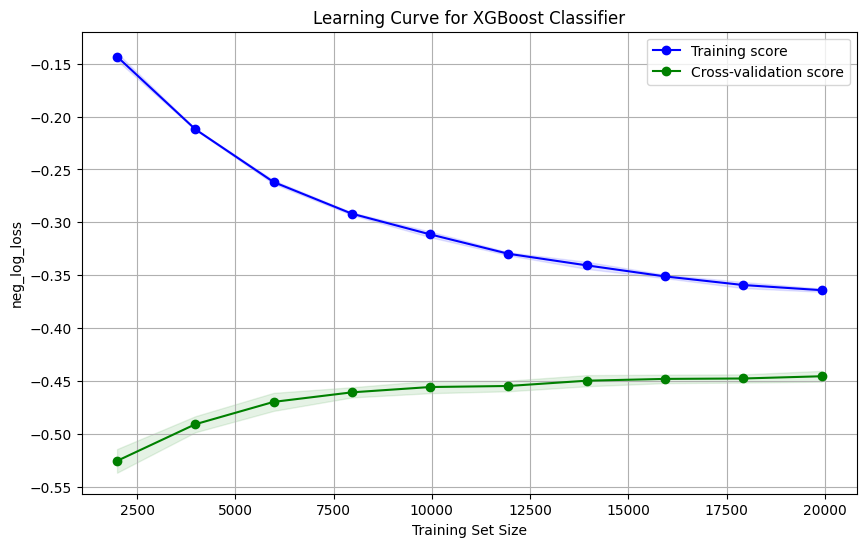

In [ ]:
from sklearn.model_selection import train_test_split


X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X_train_rfe, y_train, test_size=0.2)

best_xgb_model = XGBClassifier(**best_params, use_label_encoder=False, early_stopping_rounds=10, eval_metric='logloss')

best_xgb_model.fit(X_train_split, y_train_split, eval_set=[(X_valid, y_valid)], verbose = 0)

params = best_xgb_model.get_params()


params["early_stopping_rounds"] = None
best_xgb_model.set_params(**params)


train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model, X_train_rfe, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.xlabel('Training Set Size')
plt.ylabel('neg_log_loss')
plt.title('Learning Curve for XGBoost Classifier')
plt.legend(loc='best')
plt.grid()
plt.show()


c:\Users\tommy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:13:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


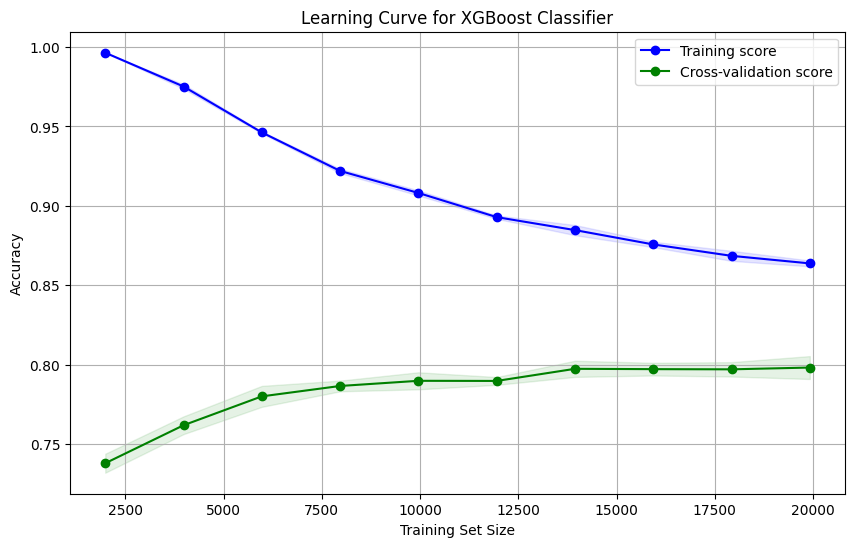

In [ ]:
from sklearn.model_selection import train_test_split


X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X_train_rfe, y_train, test_size=0.2)

best_xgb_model = XGBClassifier(**best_params, use_label_encoder=False, early_stopping_rounds=10, eval_metric='logloss')

best_xgb_model.fit(X_train_split, y_train_split, eval_set=[(X_valid, y_valid)], verbose = 0)

params = best_xgb_model.get_params()


params["early_stopping_rounds"] = None
best_xgb_model.set_params(**params)


train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model, X_train_rfe, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for XGBoost Classifier')
plt.legend(loc='best')
plt.grid()
plt.show()


In [52]:
import pandas as pd
import pickle

with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

# SVM (skipped bc takes too long)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


X = final_data.iloc[:, 4:-5]
y = final_data['spanish_bilingual']


smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, )


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


model = SVC(kernel='linear')  
rfe = RFE(model, n_features_to_select=30)  
X_train_rfe = rfe.fit_transform(X_train_pca, y_train)
X_test_rfe = rfe.transform(X_test_pca)


param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf'],
}

svm_model = SVC()


skf = StratifiedKFold(n_splits=5, shuffle=True, )
random_search = RandomizedSearchCV(
    svm_model, 
    param_distributions=param_grid,
    n_iter=50, 
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train_rfe, y_train)


best_svm_model = random_search.best_estimator_
y_pred = best_svm_model.predict(X_test_rfe)


print(f'Best Parameters: {random_search.best_params_}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
import pandas as pd
import pickle

with open('best_svm_model.pkl', 'wb') as f:
    pickle.dump(best_svm_model, f)